# axial MRI brain tumor detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

# Dataset 

In [4]:
print(f"axial_train: {len(os.listdir('/content/drive/MyDrive/tumor/axial_MRI/train')) - 1}")
print(f"axial_test: {len(os.listdir('/content/drive/MyDrive/tumor/axial_MRI/test')) - 1}")

axial_train: 332
axial_test: 39


In [5]:
PATH = "/content/drive/MyDrive/tumor/axial_MRI/train"
bbox = pd.read_csv(os.path.join(PATH, "_annotations.csv"))

bbox.head()

,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,00254_83_jpg.rf.dc8444a939bfda955ec3a0ef668b5c...,192,256,positive,50,105,77,143
1,1,00305_113_jpg.rf.da8b7d0769c01e94571b568186f33...,256,256,positive,150,91,167,106
2,2,00097_80_jpg.rf.e31f89dee132f5da82d5e3c3fc0125...,256,256,negative,160,151,192,186
3,3,00099_154_jpg.rf.d9eb261c8c610b762f46f1e6f7cfc...,256,256,negative,90,187,107,205
4,4,00240_134_jpg.rf.dacd6bdae9ee803c1eed41507c352...,192,256,positive,85,97,106,126


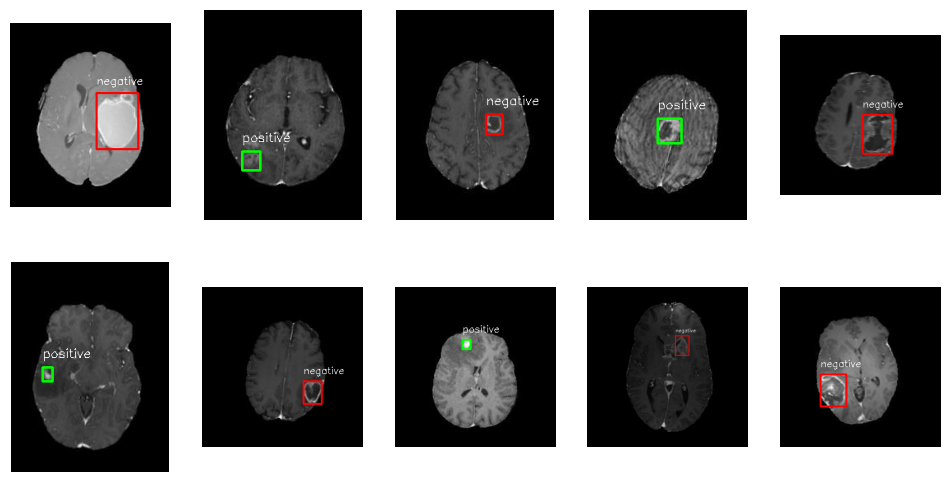

In [6]:
import random

figure = plt.figure(figsize=(12, 6)) 

row, col = 2, 5

r = random.randint(1, len(bbox))

for i in range(10):
    r = random.randint(1, len(bbox))
    value = bbox.values[r]
    img_name = value[1]
    color = (0, 255, 0) if value[4] == 'positive' else (255, 0, 0)
    txt = 'positive' if value[4] == 'positive' else 'negative'
    box = value[5:].astype('int')
    img = cv2.imread(os.path.join(PATH, img_name))
    pt1 = box[0], box[1]
    pt2 = box[2], box[3]
    cv2.rectangle(img, pt1, pt2, color, 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    text_size, _ = cv2.getTextSize(txt, font, font_scale, thickness)
    x, y = pt1
    text_x = x
    text_y = y - text_size[1]
    cv2.putText(img, txt, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)
    figure.add_subplot(row, col, i+1)
    plt.axis("off")
    plt.imshow(img)

# Selective Search

num_regional proposal: 86


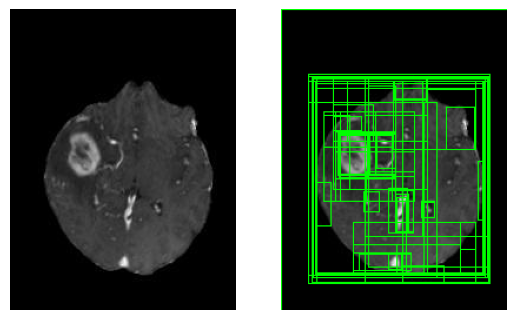

In [7]:
img = cv2.imread(f'/content/drive/MyDrive/tumor/axial_MRI/train/{bbox.values[0][1]}')

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
ss.setBaseImage(img) 
ss.switchToSelectiveSearchFast() 
rects = ss.process()

for rect in rects:
    x, y, w, h = rect
    img_out = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_out)
print(f'num_regional proposal: {len(rects)}')

In [8]:
def get_iou(bb1, bb2):

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
def selective_search_(ss, img, gtbb, iou_threshold):

    positive_sample = []
    negative_sample = []

    up_threshold, down_threshold = iou_threshold

    ss.setBaseImage(img) 
    ss.switchToSelectiveSearchFast() 
    rects = ss.process()

    for rect in rects:
        x, y, w, h = rect
        bb2 = {'x1': x,
               'y1': y,
               'x2': x+w,
               'y2': y+h} 
        iou = get_iou(gtbb, bb2)
        img_croped=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']]
        img_resized = cv2.resize(img_croped, (224, 224))

        if iou >= up_threshold:
            positive_sample.append(img_resized)
        
        elif iou <= down_threshold:
            negative_sample.append(img_resized)

    return positive_sample, negative_sample

In [10]:
cv2.setUseOptimized(True) 
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 

up_threshold = 0.5
down_threshold = 0.1

threshold = (up_threshold, down_threshold)
positive_sample = []
negative_sample = []

for value in bbox.values:
    name = value[1]
    img = cv2.imread(os.path.join(PATH, name))
    gtbox = value[5:].astype('int')
    gtbb = {
            'x1': gtbox[0],
            'y1': gtbox[1],
            'x2': gtbox[2],
            'y2': gtbox[3]
           }
    pos, neg = selective_search_(ss, img, gtbb, threshold)
    positive_sample += pos
    negative_sample += neg


len(positive_sample), len(negative_sample)

(2040, 29995)

In [11]:
negative_sample = negative_sample[:len(positive_sample)]

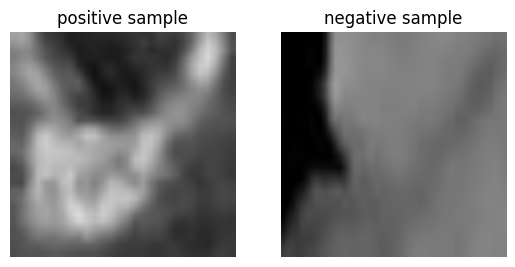

In [12]:
import random

r1 = random.randint(1, len(positive_sample) + 1)
r2 = random.randint(1, len(negative_sample) + 1)

plt.subplot(1, 2, 1)
plt.imshow(positive_sample[r1])
plt.axis('off')
plt.title('positive sample')

plt.subplot(1, 2, 2)
plt.imshow(negative_sample[r2])
plt.axis('off')
plt.title('negative sample')
plt.show()

In [13]:
positive_tumor = []
negative_tumor = []

for elem in bbox.values:
    name = elem[1]
    img = cv2.imread(os.path.join(PATH, name))
    box = elem[5:].astype('int')
    cr_img = img[box[1]:box[3], box[0]:box[2]]
    re_img = cv2.resize(cr_img, (224, 224))
    if elem[4] == 'positive':
        positive_tumor.append(re_img)
    else:
        negative_tumor.append(re_img)

# model

### ROI

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
    ])

class ROIDataset(Dataset): 
    def __init__(self, positive_sample, negative_sample):
        self.datas = np.array(positive_sample + negative_sample)
        self.labels = np.array([1 for i in range(len(positive_sample))] + [0 for i in range(len(negative_sample))])
        self.transform = transform
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, idx):
        data = self.transform(self.datas[idx])
        label = torch.tensor(self.labels[idx])
        return data, label
    
class TumorDataset(Dataset):
    def __init__(self, positive_tumor, negative_tumor):
        self.datas = positive_tumor + negative_tumor
        self.labels = [1 for i in range(len(positive_tumor))] + [0 for i in range(len(negative_tumor))]
        self.transform = transform
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, idx):
        data = self.transform(self.datas[idx])
        label = torch.tensor(self.labels[idx])
        return data, label

In [15]:
ROIData = ROIDataset(positive_sample, negative_sample)
TumorData = TumorDataset(positive_tumor, negative_tumor)
torch.save(ROIData, "roi.pt")
torch.save(TumorData, "tumor.pt")

In [16]:
device = torch.device('cuda')

In [52]:
ROIData = torch.load('/content/drive/MyDrive/tumor/roi.pt')
TumorData = torch.load('/content/drive/MyDrive/tumor/tumor.pt')

In [17]:
device

device(type='cuda')

In [18]:
class ROINet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = x.view(-1, 64 * 56 * 56)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

dataset = ROIData
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


ROImodel = ROINet().to(device)
ROIcriterion = nn.BCELoss()
ROIoptimizer = optim.Adam(ROImodel.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    for img, label in dataloader:
        image = img.to(device)
        label = label.to(device)
        ROIoptimizer.zero_grad()
        outputs = ROImodel(image)
        loss = ROIcriterion(outputs, label.float().view(-1, 1))
        loss.backward()
        ROIoptimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

Epoch 1, Loss: 1.2920346381142735
Epoch 2, Loss: 0.17721517069730908
Epoch 3, Loss: 0.11334475834155455
Epoch 4, Loss: 0.08242983254604042
Epoch 5, Loss: 0.043563367435126565
Epoch 6, Loss: 0.02305075986078009
Epoch 7, Loss: 0.028530446250442765
Epoch 8, Loss: 0.02119546198809985
Epoch 9, Loss: 0.03151181026532868
Epoch 10, Loss: 0.020146079936239403
Epoch 11, Loss: 0.03624219670200546
Epoch 12, Loss: 0.015580822015635931
Epoch 13, Loss: 0.003225663861542216
Epoch 14, Loss: 0.002324193593722157
Epoch 15, Loss: 0.004760812683073823
Epoch 16, Loss: 0.0041178606255130035
Epoch 17, Loss: 0.021043222968955888
Epoch 18, Loss: 0.02756558131852671
Epoch 19, Loss: 0.011403875801192953
Epoch 20, Loss: 0.013704019370720744


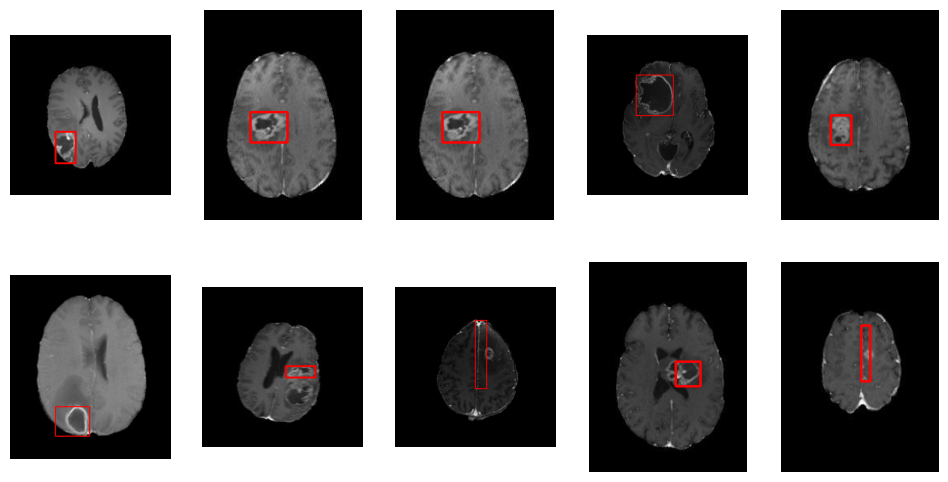

In [19]:
ROImodel.eval()

figure = plt.figure(figsize=(12, 6)) 

row, col = 2, 5

r = random.randint(1, len(bbox))

for i in range(10):
    r = random.randint(1, len(bbox))
    value = bbox.values[r]
    img_name = value[1]
    img = cv2.imread(os.path.join(PATH, img_name))
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
    ss.setBaseImage(img) 
    ss.switchToSelectiveSearchFast() 
    rects = ss.process()
    
    roimg = []
    rois = []
    for rect in rects:
        x, y, w, h = rect
        bb = {'x1': x,
               'y1': y,
               'x2': x+w,
               'y2': y+h} 
        img_croped=img[bb['y1']:bb['y2'],bb['x1']:bb['x2']]
        img_resized = cv2.resize(img_croped, (224, 224))
        roimg.append(img_resized)
        rois.append(bb)

    with torch.no_grad():
        transformed_data_list = [transform(data) for data in roimg]
        batch = torch.stack(transformed_data_list)
        output1 = ROImodel(batch.to(device))
        idx = output1.argmax()

    roi = rois[idx]
    pt1 = (roi['x1'], roi['y1'])
    pt2 = (roi['x2'], roi['y2'])
    cv2.rectangle(img, pt1, pt2, color, 2)
    figure.add_subplot(row, col, i+1)
    plt.axis("off")
    plt.imshow(img)

In [21]:
torch.save(ROImodel.state_dict(), 'ROImodel.pt')

### Tumor

In [57]:
class TumorNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(12)
        self.bn2 = nn.BatchNorm2d(24)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(24 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(-1, 24 * 56 * 56)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x


dataset = TumorData
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


Tumormodel = TumorNet().to(device)
Tumorcriterion = nn.BCELoss()
Tumoroptimizer = optim.Adam(Tumormodel.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for img, label in dataloader:
        image = img.to(device)
        label = label.to(device)
        Tumoroptimizer.zero_grad()
        outputs = Tumormodel(image)
        loss = Tumorcriterion(outputs, label.float().view(-1, 1))
        loss.backward()
        Tumoroptimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

Epoch 1, Loss: 17.771165033181507
Epoch 2, Loss: 15.518318970998129
Epoch 3, Loss: 6.503164132436116
Epoch 4, Loss: 4.066881577173869
Epoch 5, Loss: 1.2894156575202942
Epoch 6, Loss: 0.6929974853992462
Epoch 7, Loss: 0.5756295025348663
Epoch 8, Loss: 0.4487845798333486
Epoch 9, Loss: 0.4233607550462087
Epoch 10, Loss: 0.4264734486738841
Epoch 11, Loss: 0.34285008410612744
Epoch 12, Loss: 0.4706290016571681
Epoch 13, Loss: 0.4222223957379659
Epoch 14, Loss: 0.46077778687079746
Epoch 15, Loss: 0.4656368096669515
Epoch 16, Loss: 0.40651770929495495
Epoch 17, Loss: 0.4083849440018336
Epoch 18, Loss: 0.3352057288090388
Epoch 19, Loss: 0.32458600401878357
Epoch 20, Loss: 0.3100867768128713
Epoch 21, Loss: 0.26967837164799374
Epoch 22, Loss: 0.30804066359996796
Epoch 23, Loss: 0.2878447398543358
Epoch 24, Loss: 0.3057442307472229
Epoch 25, Loss: 0.262743001182874
Epoch 26, Loss: 0.2717883462707202
Epoch 27, Loss: 0.24604667723178864
Epoch 28, Loss: 0.2610759139060974
Epoch 29, Loss: 0.2598365

In [58]:
bbox_test = pd.read_csv('/content/drive/MyDrive/tumor/axial_MRI/test/_annotations.csv')

path = '/content/drive/MyDrive/tumor/axial_MRI/test/'

Tumormodel.eval()



# result

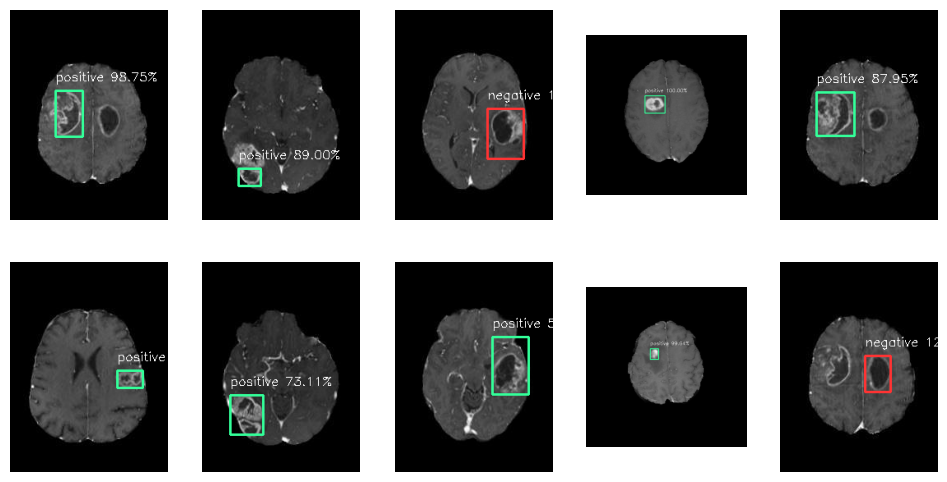

In [61]:
def inference(img, ss, models, transform, device):
    ss.setBaseImage(img) 
    ss.switchToSelectiveSearchFast() 
    rects = ss.process()
    
    ROIs = []
    bboxs = []
    
    for rect in rects:
        x, y, w, h = rect
        bb = {'x1': x,
              'y1': y,
              'x2': x+w,
              'y2': y+h} 
        img_croped=img[bb['y1']:bb['y2'],bb['x1']:bb['x2']]
        img_resized = cv2.resize(img_croped, (224, 224))
        bboxs.append(bb)
        ROIs.append(img_resized)
    
    ROImodel, Tumormodel = models

    assert ROImodel.training == False
    assert Tumormodel.training == False
    
    with torch.no_grad():
        transformed_data_list = [transform(data) for data in ROIs]
        batch = torch.stack(transformed_data_list)
        output1 = ROImodel(batch.to(device))
        idx = output1.argmax()
        ROI = ROIs[idx]
        ROI = transform(ROI)
        input_ = ROI.unsqueeze(0).to(device)
        acc = Tumormodel(input_).item() * 100

        if acc >= 50:
            color = (51, 255, 153)
            txt = f'positive {acc:.2f}%'
        else:
            color = (255, 51 ,51)
            txt = f'negative {acc:.2f}%'
        color = (51, 255, 153) if acc >= 50 else (255, 51, 51)
        pt1 = (bboxs[idx]['x1'], bboxs[idx]['y1'])
        pt2 = (bboxs[idx]['x2'], bboxs[idx]['y2'])
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        thickness = 1
        cv2.rectangle(img, pt1, pt2, color, 2)
        text_size, _ = cv2.getTextSize(txt, font, font_scale, thickness)
        x, y = pt1
        text_x = x
        text_y = y - text_size[1]
        cv2.putText(img, txt, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)

    return img

figure = plt.figure(figsize=(12, 6))
row, col = 2, 5

for i in range(10):
    r = random.randint(1, 37)
    value = bbox_test.values[r]
    img_name = value[0]
    img = cv2.imread(os.path.join(path, img_name))
    img_ = inference(img, ss, (ROImodel, Tumormodel), transform, device)
    figure.add_subplot(row, col, i+1)
    plt.axis('off')
    plt.imshow(img_)